In [2]:
import tensorflow as tf
import cv2
import numpy as np
import json

In [3]:
def load_img(x):
    bytes_img=tf.io.read_file(x)
    ima=tf.io.decode_jpeg(bytes_img)
    return ima

In [4]:
train_image=tf.data.Dataset.list_files('data/aug_data/images/*.jpg',shuffle=False)
train_image=train_image.map(load_img)
train_image=train_image.map(lambda x:tf.image.resize(x,(120,120)))
train_image=train_image.map(lambda x: x/255)


In [5]:
val_image=tf.data.Dataset.list_files('data/aug_data/val/*.jpg',shuffle=False)
val_image=val_image.map(load_img)
val_image=val_image.map(lambda x:tf.image.resize(x,(120,120)))
val_image=val_image.map(lambda x: x/255)

In [6]:
# val_image.as_numpy_iterator().next()

In [51]:
import tensorflow as tf
import json

def load_labels(label_path):
    label_path_str = label_path.numpy().decode('utf-8')
    with open(label_path_str, 'r', encoding="utf-8") as f:
        label = json.load(f)
    class_label = tf.convert_to_tensor([label['class']], dtype=tf.uint8)
    bbox = tf.convert_to_tensor(label['bbox'], dtype=tf.float16)
    return class_label, bbox


In [49]:
train_labels = tf.data.Dataset.list_files('data/aug_data/images/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
def set_shapes(class_label, bbox):
    class_label.set_shape([1])
    bbox.set_shape([4])  # Assuming bbox is a 4-element vector
    return class_label, bbox

# Create the dataset from the JSON label files
train_labels = tf.data.Dataset.list_files('data/aug_data/images/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# Set shapes for each element
train_labels = train_labels.map(lambda class_label, bbox: set_shapes(class_label, bbox))

# Function to print shapes of elements in the dataset
def print_shapes(class_label, bbox):
    print("Shape of class_label:", class_label.shape)
    print("Shape of bbox:", bbox.shape)
    return class_label, bbox

# Apply the function to print shapes
train_labels = train_labels.map(print_shapes)

# Iterate over the dataset to print shapes of the elements
for class_label, bbox in train_labels.take(5):  # Take a few examples to print
    pass


Shape of class_label: (1,)
Shape of bbox: (4,)


In [9]:
type(train_labels)

tensorflow.python.data.ops.map_op._MapDataset

In [108]:
val_label=tf.data.Dataset.list_files('data/aug_data/val/*.json',shuffle=False)
val_label=val_label.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [109]:
val_label = val_label.map(lambda class_label, bbox: set_shapes(class_label, bbox))

In [110]:
len(train_image),len(val_image),len(train_labels),len(val_label)

(5880, 1320, 5880, 1320)

In [81]:
t=train_labels.as_numpy_iterator()

In [82]:
t.next()

(array([1], dtype=uint8),
 array([0.5786, 0.363 , 0.9844, 0.984 ], dtype=float16))

In [83]:
len(train)

735

In [11]:
# train_label=tf.data.Dataset.list_files('data/aug_data/images/*.json')
# train_label=train_label.map(lambda x: tf.py_function(load_label,[x],[tf.uint8, tf.float16]))

In [111]:
train = tf.data.Dataset.zip((train_image, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [112]:
val = tf.data.Dataset.zip((val_image, val_label))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [86]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3198 , 0.00247, 0.82   , 0.677  ],
        [0.304  , 0.264  , 0.994  , 0.9985 ],
        [0.4094 , 0.10767, 1.     , 0.931  ],
        [0.1903 , 0.2944 , 0.8765 , 0.999  ],
        [0.4397 , 0.05258, 1.     , 0.671  ],
        [0.5317 , 0.0943 , 1.     , 0.918  ],
        [0.2769 , 0.     , 0.967  , 0.7314 ],
        [0.1179 , 0.3594 , 0.7007 , 0.9976 ]], dtype=float16))

In [87]:
data_sample=train.as_numpy_iterator()
res=data_sample.next()


In [88]:
# for i in res:
    # print(i.shape)

In [89]:
import matplotlib.pyplot as plt

In [90]:
# train_image.as_numpy_iterator().next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


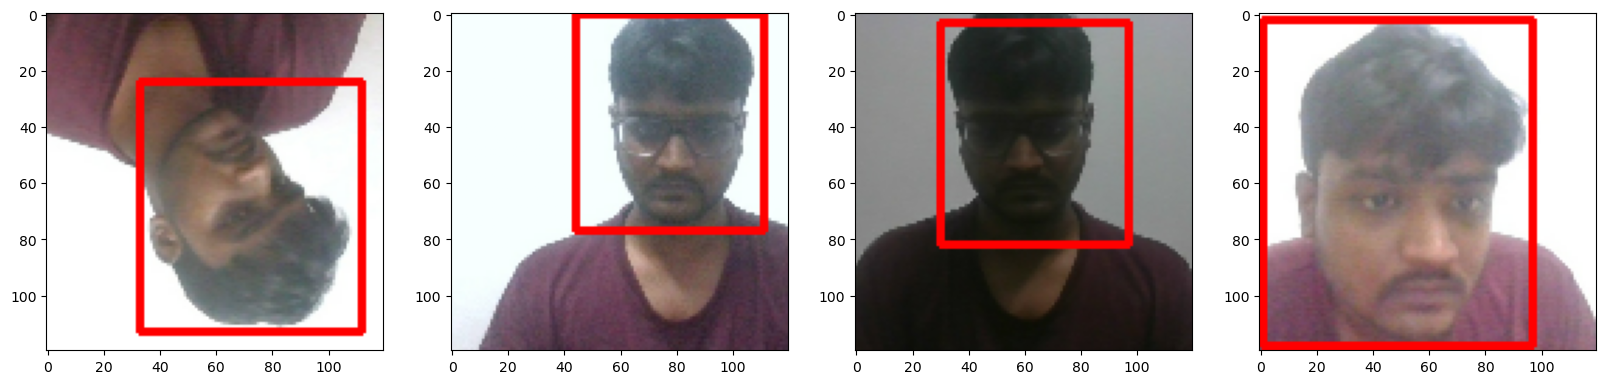

In [91]:
# fig,idx=plt.subplots(ncols=4,figsize=(20,20))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    # print(sample_coord)
    # print(sample_image)
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
plt.show()

In [113]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [114]:
vgg = VGG16(include_top=False)

In [115]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [116]:
facetracker = build_model()

In [117]:
X, y = train.as_numpy_iterator().next()

In [118]:

classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


In [119]:

for idx, item in enumerate(y):
    if item.shape!=(8,4) or (8,1):
        print()
        # If item is a NumPy array
        # print(f"Shape of item {idx}: {item.shape}")
    # elif isinstance(item, tf.Tensor):  # If item is a TensorFlow tensor
    #     print(f"Shape of item {idx}: {item.shape.as_list()}")
    # else:
    #     print(f"Item {idx} is of type {type(item)}, not a NumPy array or TensorFlow tensor")


In [122]:
batches_per_epoch = len(train)

In [123]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [124]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [125]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Model

class FaceTracker(tf.keras.Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        # Debugging prints
        print("Shape of X:", X.shape)
        print("Shape of y[0]:", y[0].shape)
        print("Shape of y[1]:", y[1].shape)

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [127]:
model = FaceTracker(facetracker)

In [128]:
model.compile(opt, classloss, regressloss)

In [129]:
logdir='logs'

In [130]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [131]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
Shape of X: (None, 120, 120, None)
Shape of y[0]: (None, 1)
Shape of y[1]: (None, 4)
Shape of X: (None, 120, 120, None)
Shape of y[0]: (None, 1)
Shape of y[1]: (None, 4)
735/735 ━━━━━━━━━━━━━━━━━━━━ 607s 813ms/step - class_loss: 0.0569 - regress_loss: 0.2357 - total_loss: 0.2642 - val_class_loss: 0.0124 - val_regress_loss: 0.1281 - val_total_loss: 0.1343
Epoch 2/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 603s 816ms/step - class_loss: 0.0265 - regress_loss: 0.0863 - total_loss: 0.0996 - val_class_loss: 0.6603 - val_regress_loss: 0.5806 - val_total_loss: 0.9107
Epoch 3/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 605s 818ms/step - class_loss: 0.0201 - regress_loss: 0.0591 - total_loss: 0.0691 - val_class_loss: 0.0291 - val_regress_loss: 0.1458 - val_total_loss: 0.1603
Epoch 4/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 605s 818ms/step - class_loss: 0.0233 - regress_loss: 0.0699 - total_loss: 0.0815 - val_class_loss: 0.6689 - val_regress_loss: 2.0544 - val_total_loss: 2.3888
Epoch 5/10
735/735 ━━━━━━━━━━━━━━━━━━━

In [138]:
model.save('new_model.h5')

In [142]:
facetracker.save('facetracker.keras')

In [1]:
loaded_model = tf.keras.models.load_model('facetracker.keras')

NameError: name 'tf' is not defined

In [1]:
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.keras')


In [2]:
import cv2
import tensorflow as tf
import numpy as np

In [6]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    # frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [640,480]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [640,480]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        # cv2.rectangle(frame, 
        #               tuple(np.add(np.multiply(sample_coords[:2], [640,480]).astype(int), 
        #                             [0,-30])),
        #               tuple(np.add(np.multiply(sample_coords[:2], [640,480]).astype(int),
        #                             [80,0])), 
        #                     (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Nematullah', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release() 
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━

In [5]:
ap.release() 
cv2.destroyAllWindows()

NameError: name 'ap' is not defined

In [40]:
def preprocess_data(X, y):
    X = tf.convert_to_tensor(X)
    y_class = tf.convert_to_tensor(y[0])
    y_loc = tf.convert_to_tensor(y[1])
    return X, (y_class, y_loc)

train = train.map(preprocess_data).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val = val.map(preprocess_data).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [45]:
train_step(train,)

ValueError: too many values to unpack (expected 2)

In [46]:
x,y=train

ValueError: too many values to unpack (expected 2)

In [61]:
import tensorflow as tf
import numpy as np

# Example data creation (simulating 5880 items)
train_image = tf.data.Dataset.from_tensor_slices(np.random.rand(5880, 64, 64, 3))  # 5880 images of 64x64 with 3 channels
train_labels = tf.data.Dataset.from_tensor_slices(np.random.randint(0, 10, size=(5880, 1)))  # 5880 labels

# Zipping the datasets together
train = tf.data.Dataset.zip((train_image, train_labels))

# Loop over each array in the dataset and get the shape
for image, label in train.as_numpy_iterator():
    print(f"Image shape: {image.shape}, Label shape: {label.shape}")


Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label shape: (1,)
Image shape: (64, 64, 3), Label 

In [ ]:


# Loop over each array in the dataset and get the shape
for image, label in train.as_numpy_iterator():
    if image.shape!=


In [136]:
from tensorflow.keras.models import load_model
loaded_model = load_model('my_model.keras')


TypeError: Could not locate class 'FaceTracker'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'FaceTracker', 'config': {'name': 'face_tracker_5', 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'FaceTracker', 'compile_config': {'loss': None, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}